In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [4]:
image_size = (256,256)
batch_size = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Potato_leaves_dataset/',
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size)

Found 2152 files belonging to 3 classes.


In [5]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

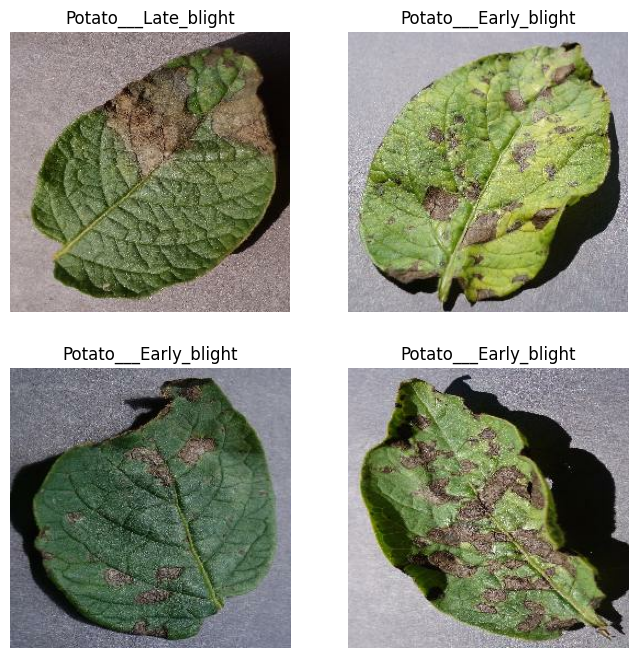

In [17]:
plt.figure(figsize=(8,8))
for i , l in dataset.take(1):
    for j in range(4):
        ax = plt.subplot(2,2,j+1)
        plt.imshow(i[j].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(classes[l[j]])

In [11]:
train_size = 0.8
train_ds = dataset.take(int(len(dataset)*train_size))
len(train_ds)

54

In [12]:
rem_ds = dataset.skip(len(train_ds))
len(rem_ds)

14

In [13]:
val_ds = rem_ds.take(int(len(rem_ds)/2))
len(val_ds)

7

In [14]:
test_ds = rem_ds.skip(len(val_ds))
len(test_ds)

7

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescaling = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1./255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [14]:
input_shape=(256,256,3)
model = tf.keras.Sequential([
    resize_and_rescaling,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

In [15]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [16]:
history = model.fit(train_ds , validation_data= val_ds, epochs=50, verbose=1, batch_size=32)

Epoch 1/50
54/54 [==============================] - 22s 188ms/step - loss: 0.8720 - accuracy: 0.5197 - val_loss: 0.8292 - val_accuracy: 0.6429
Epoch 2/50
54/54 [==============================] - 10s 178ms/step - loss: 0.4753 - accuracy: 0.8102 - val_loss: 0.5910 - val_accuracy: 0.7723
Epoch 3/50
54/54 [==============================] - 10s 176ms/step - loss: 0.3454 - accuracy: 0.8634 - val_loss: 0.3693 - val_accuracy: 0.8527
Epoch 4/50
54/54 [==============================] - 9s 175ms/step - loss: 0.2006 - accuracy: 0.9265 - val_loss: 0.3294 - val_accuracy: 0.8705
Epoch 5/50
54/54 [==============================] - 9s 175ms/step - loss: 0.1998 - accuracy: 0.9288 - val_loss: 0.3546 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 10s 179ms/step - loss: 0.1743 - accuracy: 0.9369 - val_loss: 0.2805 - val_accuracy: 0.8973
Epoch 7/50
54/54 [==============================] - 10s 183ms/step - loss: 0.1738 - accuracy: 0.9340 - val_loss: 0.2363 - val_accuracy: 0.9107
E

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.save("model.h5")

In [16]:
from tensorflow.keras.models import load_model
model = load_model("model.h5")

In [17]:
model.evaluate(test_ds)

7/7 [==============================] - 10s 48ms/step - loss: 0.0555 - accuracy: 0.9900


[0.055459752678871155, 0.9900000095367432]

actual class: Potato___Early_blight
1/1 [==============================] - 0s 187ms/step
predicted class: Potato___Late_blight


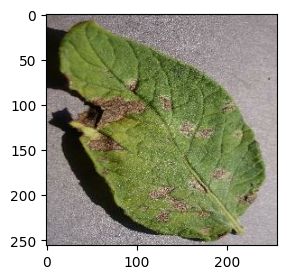

In [21]:
plt.figure(figsize=(3,3))
for i , l in test_ds.take(1):
        print(f"actual class: {classes[l[j]]}")
        plt.imshow(i[j].numpy().astype("uint8"))
        print(f"predicted class: {classes[np.argmax(model.predict(i)[0])]}")

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

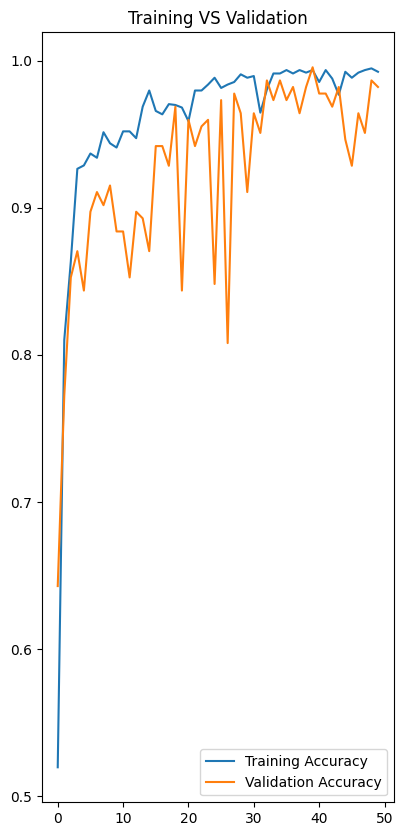

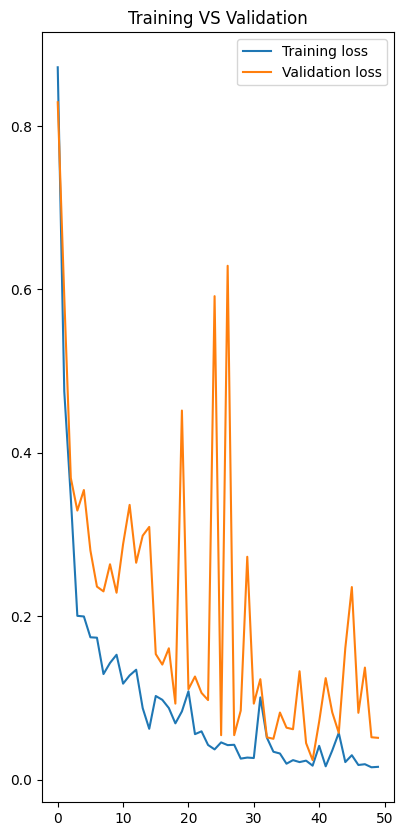

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(50), history.history["accuracy"], label="Training Accuracy")
plt.plot(range(50), history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training VS Validation")
plt.legend(loc="lower right")

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(50), history.history["loss"], label="Training loss")
plt.plot(range(50), history.history["val_loss"], label="Validation loss")
plt.title("Training VS Validation")
plt.legend(loc="upper right")
plt.show()

In [25]:
predictions = model.predict(test_ds)
predictions_lables=np.argmax(predictions, axis=1)

true_lables = []
for img , lable in test_ds:
    true_lables.extend(lable.numpy())

print(f"The number of flase predictions are {np.sum(true_lables != predictions_lables)} out of {len(true_lables)}")

7/7 [==============================] - 0s 56ms/step
The number of flase predictions are 81 out of 200


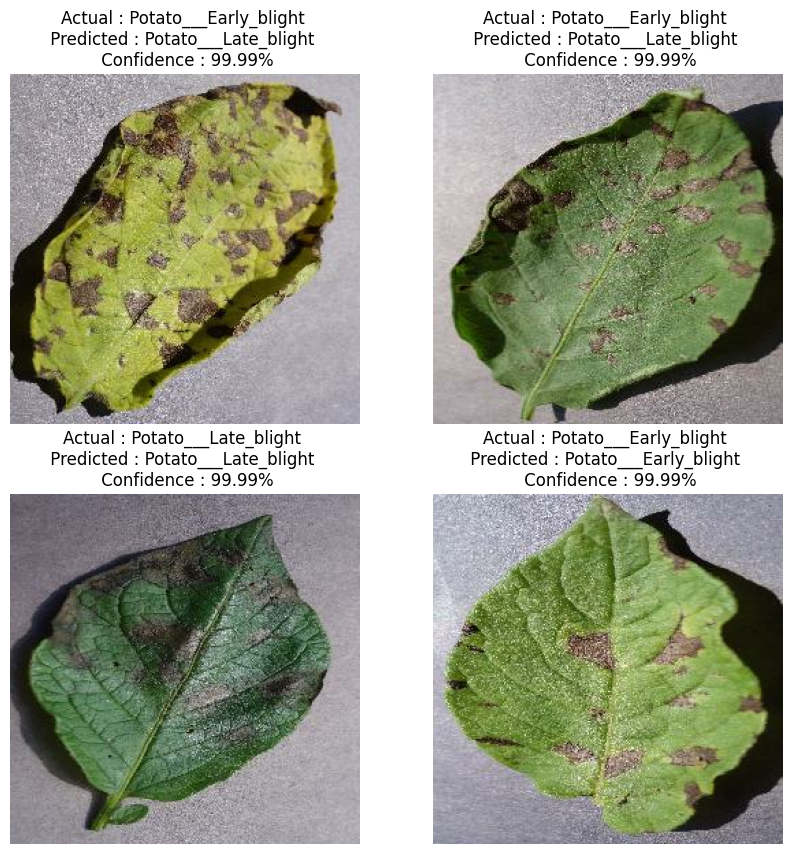

In [77]:
plt.figure(figsize=(10,10))
for img , lable in test_ds.take(1):
    for i in range(4):
        ax= plt.subplot(2,2,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        confidence = round((100 * np.max(predictions[0])),2)
        plt.title(f"Actual : {classes[lable[i]]} \n Predicted : {classes[predictions_lables[i]]}  \n Confidence : {confidence}%")
        
        plt.axis("off")


In [29]:
true_labels = np.array(true_lables)  
predictions_labels = np.array(predictions_lables) 

In [30]:
report = classification_report(true_labels, predictions_labels, target_names=['Early Blight', 'Late Blight', 'Healthy'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

Early Blight       0.61      0.62      0.62        87
 Late Blight       0.66      0.64      0.65        98
     Healthy       0.12      0.13      0.13        15

    accuracy                           0.59       200
   macro avg       0.46      0.47      0.47       200
weighted avg       0.60      0.59      0.60       200



In [31]:
conf_matrix = confusion_matrix(true_labels, predictions_labels)

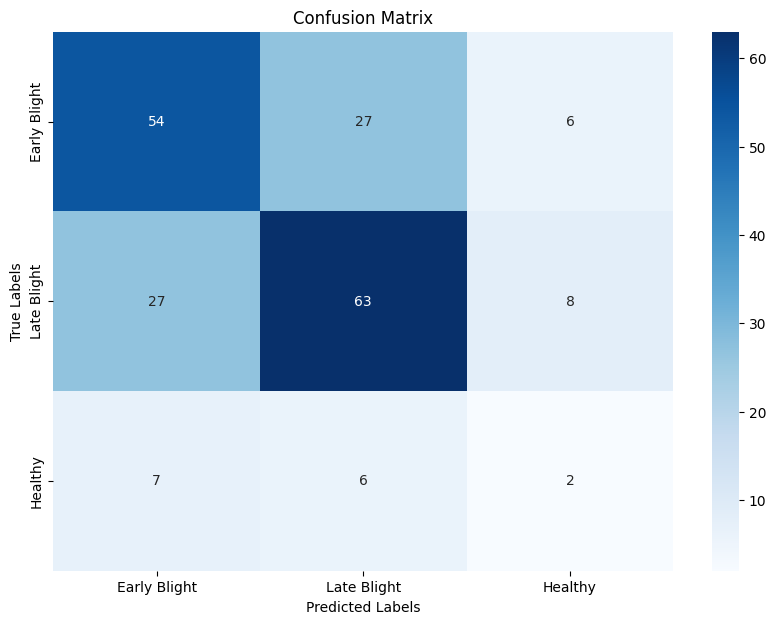

In [32]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Early Blight', 'Late Blight', 'Healthy'], yticklabels=['Early Blight', 'Late Blight', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()